<a href="https://colab.research.google.com/github/leogalbu/Mineral-Rocks-Image-Classification/blob/Model_1_Quartz_Pyrite_Binary/Model_1_Quartz_Pyrite_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [33]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import numpy as np

## Keras
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten
from keras import Sequential

## Download the data

In [1]:
!wget https://www.dropbox.com/s/dq4wf6crqg8ecqv/QuartzPyriteImages.rar

--2022-09-07 13:05:28--  https://www.dropbox.com/s/dq4wf6crqg8ecqv/QuartzPyriteImages.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/dq4wf6crqg8ecqv/QuartzPyriteImages.rar [following]
--2022-09-07 13:05:29--  https://www.dropbox.com/s/raw/dq4wf6crqg8ecqv/QuartzPyriteImages.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc073203d319541b12b5624d1498.dl.dropboxusercontent.com/cd/0/inline/BscoU-ykcaYUo45m75dZx1ht1gvTERUz-TkTH5mxVB6mXBItOvEeOSdUAWID3EoXnMsuFhkKKWSbmL1etQagmrJzSwe-YJi-eRHlzx7GiHPhx_S_2RkRGseVCHFChdvPrHjBOgTf5X1qZQxnK3LioLSVY--BvVJx1MZENTfxICYChg/file# [following]
--2022-09-07 13:05:29--  https://uc073203d319541b12b5624d1498.dl.dropboxusercontent.com/cd/0/inline/BscoU-ykcaYUo45m75dZx1ht1gvTERUz-TkTH5mxVB6mXBItOv

## Extract the dataset

In [2]:
!unrar x "/content/QuartzPyriteImages.rar" "/content/QuartzPyriteImages/";


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/QuartzPyriteImages.rar

Creating    /content/QuartzPyriteImages                               OK
Creating    /content/QuartzPyriteImages/train                         OK
Creating    /content/QuartzPyriteImages/train/Pyrite                  OK
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1.jpg          0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1002.jpg       0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1004.jpg       0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1005.jpg       0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1007.jpg       0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1008.jpg       0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1011.jpg       0%  OK 
Extracting  /conten

## Setting the train, validation and test directory

In [3]:
train_dir = 'QuartzPyriteImages/train'
val_dir = 'QuartzPyriteImages/validation'
test_dir = 'QuartzPyriteImages/test'

In [56]:
from PIL import Image

num_skipped = 0

for folder_name in ("test/Pyrite", "train/Pyrite", "validation/Pyrite"):
    folder_path = os.path.join("QuartzPyriteImages", folder_name)
    print(folder_path)
    for fname in os.listdir(folder_path):
        print(fname)
        fpath = os.path.join(folder_path, fname)
        #print(fpath)
        if fname.endswith('.jpg'):
            print('if')
            try:
                img = Image.open(fpath) # open the image file
                print(img)
                #print("%s", fpath)
                exif_data = img._getexif()
                img.verify() # verify that it is, in fact an image
            except:
                num_skipped += 1
                # Delete corrupted image
                os.remove(fpath)
print("PIL deleted %d images" % num_skipped)


QuartzPyriteImages/test/Pyrite
Pyrite_531.jpg
if
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x667 at 0x7FA91E1BF510>
Pyrite_1151.jpg
if
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=485x454 at 0x7FA91AEACF90>
Pyrite_857.jpg
if
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FA91E1BF350>
Pyrite_628.jpg
if
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=432x432 at 0x7FA91E1BF690>
Pyrite_157.jpg
if
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x800 at 0x7FA91E1E1250>
Pyrite_1029.jpg
if
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=620x608 at 0x7FA91AEC7E90>
Pyrite_280.jpg
if
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=439x620 at 0x7FA923518890>
Pyrite_503.jpg
if
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=456x432 at 0x7FA923518AD0>
Pyrite_257.jpg
if
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=834x722 at 0x7FA91AEB2B10>
Pyrite_848.jpg
if
<PIL.JpegImagePlugin.JpegImageFile image mode=R

In [99]:
import os
import cv2
import imghdr

def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                  bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir =r'QuartzPyriteImages/test/'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  Pyrite
processing class directory  Quartz
 no improper image files were found


## Loading Datasets with image_dataset_from_directory

In [100]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
print('Setting up Training data')
train_data_set = tf.keras.preprocessing.image_dataset_from_directory(train_dir, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, label_mode='binary')
print('Setting up Validation data')
validation_data_set = tf.keras.preprocessing.image_dataset_from_directory(val_dir, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, label_mode='binary')
print('Setting up Test data')
test_data_set = tf.keras.preprocessing.image_dataset_from_directory(test_dir, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, label_mode='binary')

Setting up Training data
Found 1486 files belonging to 2 classes.
Setting up Validation data
Found 498 files belonging to 2 classes.
Setting up Test data
Found 498 files belonging to 2 classes.


## View Random Image

In [101]:
class_names = train_data_set.class_names

def random_image_picker(target_dir, target_class):
  target_folder = target_dir + '/' + target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")
  #print(f"Image shape: {img.shape}")

  return img

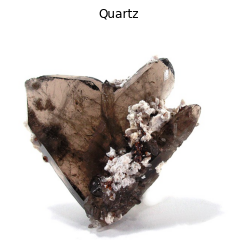

In [102]:
img = random_image_picker("QuartzPyriteImages/train", "Quartz")

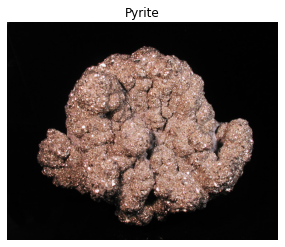

In [103]:
img = random_image_picker("QuartzPyriteImages/train", "Pyrite")

## Build the Base CNN Model from Scratch (No data augmentation)

In [104]:
from tensorflow.keras.layers.experimental import preprocessing

model_1_baseline = Sequential([
    preprocessing.Rescaling(1./255),
    Conv2D(32,3, input_shape=(224,224,3), activation='relu'),
    MaxPool2D(),
    Conv2D(64,3,activation='relu'),
    MaxPool2D(),
    Conv2D(128, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(256,3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [105]:
# Compile the model
model_1_baseline.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam())

In [108]:
# Fit the Model
history_1_baseline = model_1_baseline.fit(test_data_set, epochs=20, steps_per_epoch=len(test_data_set), validation_data=test_data_set, validation_steps=len(test_data_set))

Epoch 1/20


InvalidArgumentError: ignored

In [86]:
!ls -a QuartzPyriteImages/train/Quartz

.		 Quartz_151.jpg  Quartz_353.jpg  Quartz_565.jpg  Quartz_772.jpg
..		 Quartz_153.jpg  Quartz_355.jpg  Quartz_568.jpg  Quartz_77.jpg
Quartz_1002.jpg  Quartz_155.jpg  Quartz_357.jpg  Quartz_569.jpg  Quartz_780.jpg
Quartz_1005.jpg  Quartz_156.jpg  Quartz_359.jpg  Quartz_56.jpg	 Quartz_786.jpg
Quartz_1006.jpg  Quartz_159.jpg  Quartz_35.jpg	 Quartz_571.jpg  Quartz_789.jpg
Quartz_1007.jpg  Quartz_15.jpg	 Quartz_361.jpg  Quartz_572.jpg  Quartz_78.jpg
Quartz_1008.jpg  Quartz_160.jpg  Quartz_362.jpg  Quartz_573.jpg  Quartz_790.jpg
Quartz_1010.jpg  Quartz_162.jpg  Quartz_363.jpg  Quartz_575.jpg  Quartz_792.jpg
Quartz_1011.jpg  Quartz_163.jpg  Quartz_364.jpg  Quartz_578.jpg  Quartz_794.jpg
Quartz_1015.jpg  Quartz_164.jpg  Quartz_365.jpg  Quartz_57.jpg	 Quartz_797.jpg
Quartz_1016.jpg  Quartz_165.jpg  Quartz_366.jpg  Quartz_580.jpg  Quartz_799.jpg
Quartz_1017.jpg  Quartz_166.jpg  Quartz_369.jpg  Quartz_581.jpg  Quartz_79.jpg
Quartz_1019.jpg  Quartz_168.jpg  Quartz_36.jpg	 Quartz_582.jpg  Quartz_7

In [126]:
import pathlib
data_dir = pathlib.Path(train_dir)
data_dir

PosixPath('QuartzPyriteImages/train')

In [127]:
from struct import unpack
from tqdm import tqdm_notebook

marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                raise TypeError("issue reading jpeg file")       


bads = []

for img in tqdm_notebook(list(data_dir.glob('*/*.jpg'))):
    image = str(img)
    print(image)
    image = JPEG(image) 
    try:
        image.decode()   
    except:
        bads.append(img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1486 [00:00<?, ?it/s]

QuartzPyriteImages/train/Pyrite/Pyrite_274.jpg
QuartzPyriteImages/train/Pyrite/Pyrite_875.jpg
QuartzPyriteImages/train/Pyrite/Pyrite_1084.jpg
QuartzPyriteImages/train/Pyrite/Pyrite_541.jpg
QuartzPyriteImages/train/Pyrite/Pyrite_787.jpg
QuartzPyriteImages/train/Pyrite/Pyrite_1209.jpg
QuartzPyriteImages/train/Pyrite/Pyrite_693.jpg
QuartzPyriteImages/train/Pyrite/Pyrite_151.jpg
QuartzPyriteImages/train/Pyrite/Pyrite_1160.jpg
QuartzPyriteImages/train/Pyrite/Pyrite_281.jpg
QuartzPyriteImages/train/Pyrite/Pyrite_1290.jpg
QuartzPyriteImages/train/Pyrite/Pyrite_832.jpg
QuartzPyriteImages/train/Pyrite/Pyrite_686.jpg
QuartzPyriteImages/train/Pyrite/Pyrite_134.jpg
QuartzPyriteImages/train/Pyrite/Pyrite_189.jpg
QuartzPyriteImages/train/Pyrite/Pyrite_1016.jpg
QuartzPyriteImages/train/Pyrite/Pyrite_1021.jpg
QuartzPyriteImages/train/Pyrite/Pyrite_1039.jpg
QuartzPyriteImages/train/Pyrite/Pyrite_603.jpg
QuartzPyriteImages/train/Pyrite/Pyrite_588.jpg
QuartzPyriteImages/train/Pyrite/Pyrite_315.jpg
Quartz

In [128]:
bads

[PosixPath('QuartzPyriteImages/train/Pyrite/Pyrite_832.jpg'),
 PosixPath('QuartzPyriteImages/train/Pyrite/Pyrite_1021.jpg'),
 PosixPath('QuartzPyriteImages/train/Pyrite/Pyrite_850.jpg'),
 PosixPath('QuartzPyriteImages/train/Pyrite/Pyrite_1101.jpg'),
 PosixPath('QuartzPyriteImages/train/Pyrite/Pyrite_770.jpg'),
 PosixPath('QuartzPyriteImages/train/Pyrite/Pyrite_143.jpg'),
 PosixPath('QuartzPyriteImages/train/Pyrite/Pyrite_1060.jpg'),
 PosixPath('QuartzPyriteImages/train/Pyrite/Pyrite_351.jpg'),
 PosixPath('QuartzPyriteImages/train/Pyrite/Pyrite_1279.jpg'),
 PosixPath('QuartzPyriteImages/train/Pyrite/Pyrite_1068.jpg'),
 PosixPath('QuartzPyriteImages/train/Pyrite/Pyrite_1286.jpg'),
 PosixPath('QuartzPyriteImages/train/Pyrite/Pyrite_239.jpg'),
 PosixPath('QuartzPyriteImages/train/Pyrite/Pyrite_911.jpg'),
 PosixPath('QuartzPyriteImages/train/Pyrite/Pyrite_1202.jpg'),
 PosixPath('QuartzPyriteImages/train/Pyrite/Pyrite_276.jpg'),
 PosixPath('QuartzPyriteImages/train/Pyrite/Pyrite_114.jpg'),
 